# Ray Marching to Assess Light Interaction with Fractal Surfaces

### All imports

In [18]:
import numpy as np
import math
from PIL import Image

### Constants and Fractal Parameters

In [19]:
# Constants
POWER = 8  # Power used in the Mandelbulb formula
MAX_ITER = 32  # Maximum iterations for the Mandelbulb computation
THRESHOLD = 2.0  # Escape threshold
MAX_DIST = 10.0  # Maximum ray march distance
MIN_DIST = 0.001  # Minimum distance to consider hit
DELTA = 1e-6  # Delta for normal calculation

### Image Resolution

In [20]:
# Resolution of the output image
WIDTH = 400
HEIGHT = 300

### Camera Settings

In [21]:
# Camera settings
CAM_POS = np.array([0, 0, -3])  # Camera position
TARGET = np.array([0, 0, 0])  # Target looking at
FOV = math.pi / 4  # Field of view in radians


### Calculate ray direction from camera position and pixel position

In [22]:
def get_ray_dir(x, y):
    aspect_ratio = WIDTH / HEIGHT
    px = (2 * (x + 0.5) / WIDTH - 1) * aspect_ratio * math.tan(FOV / 2)
    py = (1 - 2 * (y + 0.5) / HEIGHT) * math.tan(FOV / 2)
    ray_dir = np.array([px, py, 1]) - CAM_POS
    ray_dir /= np.linalg.norm(ray_dir)
    return ray_dir

### Distance estimation between camera and mandelbulb

In [23]:
# Mandelbulb distance estimator
def mandelbulb_dist(pos):
    z = pos.copy()
    dr = 1.0
    r = 0.0
    for i in range(MAX_ITER):
        r = np.linalg.norm(z)
        if r > THRESHOLD:
            break
        # Convert to polar coordinates
        theta = math.atan2(math.sqrt(z[0]**2 + z[1]**2), z[2])
        phi = math.atan2(z[1], z[0])
        dr = r**POWER * dr * POWER + 1.0
        # Scale and rotate the point
        zr = r**POWER
        theta *= POWER
        phi *= POWER
        z = zr * np.array([
            math.sin(theta) * math.cos(phi),
            math.sin(theta) * math.sin(phi),
            math.cos(theta)
        ]) + pos
    return 0.5 * math.log(r) * r / dr

### Ray Marching

In [24]:
# Ray marching algorithm to find distance to the fractal surface
def ray_march(orig, dir):
    depth = 0.0
    for _ in range(100):
        p = orig + depth * dir
        dist = mandelbulb_dist(p)
        depth += dist
        if dist < MIN_DIST or depth > MAX_DIST:
            break
    return depth


# Compute the normal at a point on the fractal surface
def get_normal(p):
    normal = np.array([
        mandelbulb_dist(p + np.array([DELTA, 0, 0])) - mandelbulb_dist(p - np.array([DELTA, 0, 0])),
        mandelbulb_dist(p + np.array([0, DELTA, 0])) - mandelbulb_dist(p - np.array([0, DELTA, 0])),
        mandelbulb_dist(p + np.array([0, 0, DELTA])) - mandelbulb_dist(p - np.array([0, 0, DELTA]))
    ])
    return normal / np.linalg.norm(normal)

# Simple lighting model: dot product of light direction and normal at the surface
def simple_lighting(p):
    light_dir = np.array([0.0, 1.0, -1.0])  # Ensure using floating point literals
    light_dir /= np.linalg.norm(light_dir)  # Normalize the light direction
    n = get_normal(p)
    return max(np.dot(n, light_dir), 0.0)  # Calculate lighting as dot product

### Rendering

In [25]:
# Render the Mandelbulb
def render():
    image = Image.new('RGB', (WIDTH, HEIGHT))
    for x in range(WIDTH):
        for y in range(HEIGHT):
            ray_dir = get_ray_dir(x, y)
            dist = ray_march(CAM_POS, ray_dir)
            if dist < MAX_DIST:
                p = CAM_POS + dist * ray_dir
                color = int(simple_lighting(p) * 255)
                image.putpixel((x, y), (color, color, color))
            else:
                image.putpixel((x, y), (0, 0, 0))
    image.save('mandelbulb3.png')

render()

### Rendered Image 1

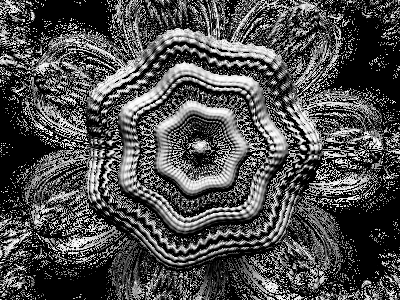

In [28]:
#Configuration:
# Constants
# POWER = 8  # Power used in the Mandelbulb formula
# MAX_ITER = 32  # Maximum iterations for the Mandelbulb computation
# THRESHOLD = 2.0  # Escape threshold
# MAX_DIST = 10.0  # Maximum ray march distance
# MIN_DIST = 0.001  # Minimum distance to consider hit
# DELTA = 1e-6  # Delta for normal calculation

# Resolution of the output image
# WIDTH = 400
# HEIGHT = 300

# Camera settings
# CAM_POS = np.array([0, 0, -3])  # Camera position
# TARGET = np.array([0, 0, 0])  # Target looking at
# FOV = math.pi / 4  # Field of view in radians


Image.open("mandelbulb3.png")

### Rendered Image 2

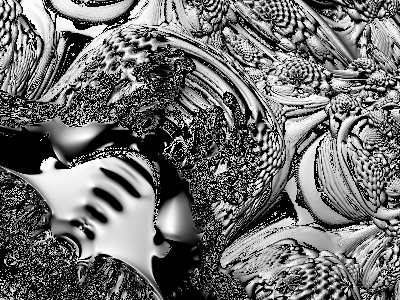

In [27]:
Image.open("mandelbulb4.png")

In [36]:
import numpy as np
from numba import jit
from PIL import Image

# Parameters
POWER = 8
MAX_ITER = 32
ESCAPE_RADIUS = 2
DELTA = 0.001
WIDTH, HEIGHT = 400, 300
FOV = np.pi / 4
ASPECT_RATIO = WIDTH / HEIGHT
CAMERA_DISTANCE = 3.0
FRAMES = 30

@jit(nopython=True)
def mandelbulb_distance(p, power=8, max_iterations=100, bailout=2.0):
    z = np.copy(p)
    dr = 1.0
    r = 0.0
    for i in range(max_iterations):
        r = np.linalg.norm(z)
        if r > bailout:
            break
        theta = np.arctan2(np.hypot(z[0], z[1]), z[2])
        phi = np.arctan2(z[1], z[0])
        zr = r**power
        dr = (power * zr / r) * dr + 1.0
        theta *= power
        phi *= power
        z = zr * np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]) + p
    return 0.5 * np.log(r) * r / dr

@jit(nopython=True)
def ray_march(origin, direction, max_dist=20, max_steps=200, eps=0.001):
    dist_traveled = 0.0
    for i in range(max_steps):
        p = origin + dist_traveled * direction
        dist = mandelbulb_distance(p)
        if dist < eps:
            return dist, p
        dist_traveled += dist
        if dist_traveled >= max_dist:
            return None, None
    return None, None

@jit(nopython=True)
def get_normal(p):
    if p is None:
        return None
    normal = np.array([
        mandelbulb_distance(p + np.array([DELTA, 0.0, 0.0])) - mandelbulb_distance(p - np.array([DELTA, 0.0, 0.0])),
        mandelbulb_distance(p + np.array([0.0, DELTA, 0.0])) - mandelbulb_distance(p - np.array([0.0, DELTA, 0.0])),
        mandelbulb_distance(p + np.array([0.0, 0.0, DELTA])) - mandelbulb_distance(p - np.array([0.0, 0.0, DELTA]))
    ]) / (2 * DELTA)
    return normal / np.linalg.norm(normal)

def render_frame(angle):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    camera_pos = np.array([CAMERA_DISTANCE * np.sin(angle), 0, CAMERA_DISTANCE * np.cos(angle)])
    look_at = np.array([0, 0, 0])
    up = np.array([0, 1, 0])
    forward = look_at - camera_pos
    right = np.cross(up, forward)
    up = np.cross(forward, right)
    forward = forward / np.linalg.norm(forward)
    right = right / np.linalg.norm(right)
    up = up / np.linalg.norm(up)

    for y in range(HEIGHT):
        for x in range(WIDTH):
            u = (x / WIDTH - 0.5) * 2 * np.tan(FOV / 2) * ASPECT_RATIO
            v = (y / HEIGHT - 0.5) * 2 * np.tan(FOV / 2)
            direction = forward + u * right + v * up
            direction /= np.linalg.norm(direction)
            dist, hit_point = ray_march(camera_pos, direction)
            if hit_point is not None:
                normal = get_normal(hit_point)
                if normal is not None:
                    # Simple lighting based on dot product between light direction and normal
                    light_dir = np.array([1, 1, 1]) - hit_point
                    light_dir /= np.linalg.norm(light_dir)
                    intensity = max(np.dot(light_dir, normal), 0)
                    color = (int(255 * intensity), int(255 * intensity), int(255 * intensity))
                    image.putpixel((x, y), color)

    image.save(f'animation/frame_{int(angle * 180 / np.pi)}.png')

def create_animation():
    for i in range(FRAMES):
        angle = 2 * np.pi * i / FRAMES
        render_frame(angle)
        print(f'Rendered frame {i+1}/{FRAMES}')

create_animation()


Rendered frame 1/30
Rendered frame 2/30
Rendered frame 3/30
Rendered frame 4/30
Rendered frame 5/30
Rendered frame 6/30
Rendered frame 7/30
Rendered frame 8/30
Rendered frame 9/30
Rendered frame 10/30
Rendered frame 11/30
Rendered frame 12/30
Rendered frame 13/30
Rendered frame 14/30
Rendered frame 15/30
Rendered frame 16/30
Rendered frame 17/30
Rendered frame 18/30
Rendered frame 19/30
Rendered frame 20/30
Rendered frame 21/30
Rendered frame 22/30
Rendered frame 23/30
Rendered frame 24/30
Rendered frame 25/30
Rendered frame 26/30
Rendered frame 27/30
Rendered frame 28/30
Rendered frame 29/30
Rendered frame 30/30


In [38]:
import numpy as np
from numba import jit
from PIL import Image

# Fractal and rendering parameters
POWER = 8
MAX_ITER = 100
ESCAPE_RADIUS = 2
DELTA = 0.001
WIDTH, HEIGHT = 400, 300
FOV = np.pi / 4
ASPECT_RATIO = WIDTH / HEIGHT
CAMERA_DISTANCE = 3.0
FRAMES = 30

@jit(nopython=True)
def mandelbulb_distance(p, power=8, max_iterations=100, bailout=2.0):
    z = np.copy(p)
    dr = 1.0
    r = 0.0
    for i in range(max_iterations):
        r = np.linalg.norm(z)
        if r > bailout:
            break
        theta = np.arctan2(np.hypot(z[0], z[1]), z[2])
        phi = np.arctan2(z[1], z[0])
        zr = r**power
        dr = (power * zr / r) * dr + 1.0
        theta *= power
        phi *= power
        z = zr * np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]) + p
    return 0.5 * np.log(r) * r / dr, i

@jit(nopython=True)
def ray_march(origin, direction, max_dist=20, max_steps=200, eps=0.001):
    dist_traveled = 0.0
    for i in range(max_steps):
        p = origin + dist_traveled * direction
        dist, iterations = mandelbulb_distance(p)
        if dist < eps:
            return dist_traveled, p, iterations
        dist_traveled += dist
        if dist_traveled >= max_dist:
            return None, None, None
    return None, None, None

def get_color(iterations, max_iterations):
    if iterations == max_iterations:
        return (0, 0, 0)  # Black for points inside the Mandelbulb
    t = iterations / max_iterations
    r = int(t * 255)  # Red increases from 0 to 255
    g = int((1 - t) * 128)  # Green goes from 128 to 0
    b = int((1 - t) * 255)  # Blue decreases from 255 to 0
    return (r, g, b)

def render_frame(angle, filename):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    camera_pos = np.array([CAMERA_DISTANCE * np.sin(angle), 0, CAMERA_DISTANCE * np.cos(angle)])
    look_at = np.array([0, 0, 0])
    up = np.array([0, 1, 0])
    forward = look_at - camera_pos
    right = np.cross(up, forward)
    up = np.cross(forward, right)
    forward = forward / np.linalg.norm(forward)
    right = right / np.linalg.norm(right)
    up = up / np.linalg.norm(up)

    for y in range(HEIGHT):
        for x in range(WIDTH):
            u = (x / WIDTH - 0.5) * 2 * np.tan(FOV / 2) * ASPECT_RATIO
            v = (y / HEIGHT - 0.5) * 2 * np.tan(FOV / 2)
            direction = forward + u * right + v * up
            direction /= np.linalg.norm(direction)
            dist, hit_point, iterations = ray_march(camera_pos, direction)
            if hit_point is not None:
                color = get_color(iterations, MAX_ITER)
                image.putpixel((x, y), color)

    image.save(filename)

def create_animation():
    for i in range(FRAMES):
        angle = 2 * np.pi * i / FRAMES
        filename = f'animation2/frame_{i:03}.png'
        render_frame(angle, filename)
        print(f'Rendered frame {i+1}/{FRAMES}')

create_animation()


Rendered frame 1/30
Rendered frame 2/30
Rendered frame 3/30
Rendered frame 4/30
Rendered frame 5/30
Rendered frame 6/30
Rendered frame 7/30
Rendered frame 8/30
Rendered frame 9/30
Rendered frame 10/30
Rendered frame 11/30
Rendered frame 12/30
Rendered frame 13/30
Rendered frame 14/30
Rendered frame 15/30
Rendered frame 16/30
Rendered frame 17/30
Rendered frame 18/30
Rendered frame 19/30
Rendered frame 20/30
Rendered frame 21/30
Rendered frame 22/30
Rendered frame 23/30
Rendered frame 24/30
Rendered frame 25/30
Rendered frame 26/30
Rendered frame 27/30
Rendered frame 28/30
Rendered frame 29/30
Rendered frame 30/30


In [41]:
import numpy as np
from numba import jit
from PIL import Image

# Fractal and rendering parameters
POWER = 8
MAX_ITER = 100
ESCAPE_RADIUS = 2
DELTA = 0.001
WIDTH, HEIGHT = 400, 300
FOV = np.pi / 4
ASPECT_RATIO = WIDTH / HEIGHT
CAMERA_DISTANCE = 3.0
FRAMES = 30

@jit(nopython=True)
def mandelbulb_distance(p, power=8, max_iterations=100, bailout=2.0):
    z = np.copy(p)
    dr = 1.0
    r = 0.0
    for i in range(max_iterations):
        r = np.linalg.norm(z)
        if r > bailout:
            break
        theta = np.arctan2(np.hypot(z[0], z[1]), z[2])
        phi = np.arctan2(z[1], z[0])
        zr = r**power
        dr = (power * zr / r) * dr + 1.0
        theta *= power
        phi *= power
        z = zr * np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]) + p
    return 0.5 * np.log(r) * r / dr, i

@jit(nopython=True)
def ray_march(origin, direction, max_dist=20, max_steps=200, eps=0.001):
    dist_traveled = 0.0
    for i in range(max_steps):
        p = origin + dist_traveled * direction
        dist, iterations = mandelbulb_distance(p)
        if dist < eps:
            return dist_traveled, p, iterations
        dist_traveled += dist
        if dist_traveled >= max_dist:
            return None, None, None
    return None, None, None

@jit(nopython=True)
def get_normal(p, delta=0.001):
    # Approximate the gradient (normal) at p
    grad = np.array([
        mandelbulb_distance(p + np.array([delta, 0, 0]))[0] - mandelbulb_distance(p - np.array([delta, 0, 0]))[0],
        mandelbulb_distance(p + np.array([0, delta, 0]))[0] - mandelbulb_distance(p - np.array([0, delta, 0]))[0],
        mandelbulb_distance(p + np.array([0, 0, delta]))[0] - mandelbulb_distance(p - np.array([0, 0, delta]))[0]
    ])
    return grad / np.linalg.norm(grad)

def normalize(v):
    return v / np.linalg.norm(v)

def simple_lighting(normal, light_dir, light_color=np.array([255, 200, 150])):
    # Lambertian reflectance model for diffuse lighting
    light_intensity = max(np.dot(normal, light_dir), 0)
    return (light_color * light_intensity).astype(int)

def render_frame(angle, filename):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    camera_pos = np.array([CAMERA_DISTANCE * np.sin(angle), 0, CAMERA_DISTANCE * np.cos(angle)])
    look_at = np.array([0, 0, 0])
    up = np.array([0, 1, 0])
    forward = look_at - camera_pos
    right = np.cross(up, forward)
    up = np.cross(forward, right)
    forward = forward / np.linalg.norm(forward)
    right = right / np.linalg.norm(right)
    up = up / np.linalg.norm(up)
    light_dir = normalize(np.array([1, 1, -1]))  # Example light direction

    for y in range(HEIGHT):
        for x in range(WIDTH):
            u = (x / WIDTH - 0.5) * 2 * np.tan(FOV / 2) * ASPECT_RATIO
            v = (y / HEIGHT - 0.5) * 2 * np.tan(FOV / 2)
            direction = normalize(forward + u * right + v * up)
            dist, hit_point, _ = ray_march(camera_pos, direction)
            if hit_point is not None:
                normal = get_normal(hit_point)
                color = simple_lighting(normal, light_dir)
                image.putpixel((x, y), tuple(color))

    image.save(filename)

def create_animation():
    for i in range(FRAMES):
        angle = 2 * np.pi * i / FRAMES
        filename = f'animation3/frame_{i:03}.png'
        render_frame(angle, filename)
        print(f'Rendered frame {i+1}/{FRAMES}')

create_animation()


Rendered frame 1/30
Rendered frame 2/30
Rendered frame 3/30
Rendered frame 4/30
Rendered frame 5/30
Rendered frame 6/30
Rendered frame 7/30
Rendered frame 8/30
Rendered frame 9/30
Rendered frame 10/30
Rendered frame 11/30
Rendered frame 12/30
Rendered frame 13/30
Rendered frame 14/30
Rendered frame 15/30
Rendered frame 16/30
Rendered frame 17/30
Rendered frame 18/30
Rendered frame 19/30
Rendered frame 20/30
Rendered frame 21/30
Rendered frame 22/30
Rendered frame 23/30
Rendered frame 24/30
Rendered frame 25/30
Rendered frame 26/30
Rendered frame 27/30
Rendered frame 28/30
Rendered frame 29/30
Rendered frame 30/30
